In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Timestamp
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [244]:


df = pd.read_csv('../bitcoinforum/6_calculating_costs/monthly_stuff.csv')
df['date'] = pd.to_datetime(df['date'])

In [245]:
seconds_in_block = 600
df['joules_per_coin'] = seconds_in_block * df['hashrate'] / (df['efficiency'] * df['coins_per_block'])
joules_per_coin = df[['date', 'joules_per_coin']]
df['joules_per_dollar'] = df['joules_per_coin'] / df['price']
df.set_index('date', inplace=True)
joules_per_dollar = df[['joules_per_dollar']]

In [246]:
joules_per_dollar

,joules_per_dollar
date,
2023-10-31,6.337577e+07
2023-09-30,6.733189e+07
2023-08-31,6.856619e+07
2023-07-31,6.431000e+07
2023-06-30,6.011127e+07
...,...
2011-06-30,5.840433e+06
2011-05-31,5.498373e+06
2011-04-30,6.587576e+06


In [247]:
electricity_cost = np.array([0.03, 0.15]) / (1000*3600)
aux_cost = np.array([1,2])


cost_per_dollar = [joules_per_dollar * e * a for (e,a) in zip(electricity_cost, aux_cost)]
cost_per_dollar = [x.rename(columns={'joules_per_dollar': 'cost_per_dollar'}) for x in cost_per_dollar]
cost_per_dollar

[            cost_per_dollar
 date                       
 2023-10-31         0.528131
 2023-09-30         0.561099
 2023-08-31         0.571385
 2023-07-31         0.535917
 2023-06-30         0.500927
 ...                     ...
 2011-06-30         0.048670
 2011-05-31         0.045820
 2011-04-30         0.054896
 2011-03-31         0.040673
 2011-02-28         0.023581
 
 [153 rows x 1 columns],
             cost_per_dollar
 date                       
 2023-10-31         5.281314
 2023-09-30         5.610991
 2023-08-31         5.713849
 2023-07-31         5.359166
 2023-06-30         5.009273
 ...                     ...
 2011-06-30         0.486703
 2011-05-31         0.458198
 2011-04-30         0.548965
 2011-03-31         0.406726
 2011-02-28         0.235811
 
 [153 rows x 1 columns]]

In [248]:
profit_per_dollar = [1-c for c in cost_per_dollar]
profit_per_dollar = [x.rename(columns={'cost_per_dollar': f'profit_per_dollar_{i}'}) for i,x in zip(["best","worst"],profit_per_dollar)]
profit_per_dollar = pd.concat(profit_per_dollar, axis=1)
#reverse the rows
profit_per_dollar = profit_per_dollar.iloc[::-1]
profit_per_dollar

,profit_per_dollar_best,profit_per_dollar_worst
date,,
2011-02-28,0.976419,0.764189
2011-03-31,0.959327,0.593274
2011-04-30,0.945104,0.451035
2011-05-31,0.954180,0.541802
2011-06-30,0.951330,0.513297
...,...,...
2023-06-30,0.499073,-4.009273
2023-07-31,0.464083,-4.359166
2023-08-31,0.428615,-4.713849


In [249]:
# same plot again but it also includes the log price, scaled from 0 to 1
price = df['price']
log_price = np.log10(df['price'])
# log_price = df['price']
log_price = log_price.iloc[::-1]
log_price_normalized = (log_price - log_price.min()) / (log_price.max() - log_price.min())
log_price_normalized = log_price_normalized.rename('log_price')


halving_dates = pd.DataFrame({
    'date': ['2012-11-28', '2016-07-09', '2020-05-11', '2024-04-01'],
})
halving_dates['date'] = pd.to_datetime(halving_dates['date'])

In [250]:
predicted_d_ln_price_df = pd.read_csv('predictions_full_data.csv') # date	predicted_d_ln_price
predicted_d_ln_price_df['date'] = pd.to_datetime(predicted_d_ln_price_df['date'])
ln_price = np.log(price)
predicted_price = predicted_d_ln_price_df.copy()

# go through each (date, predicted_d_ln_price) pair and obtain the predicted price of the next quarter
for i, row in predicted_price.iterrows():
    date = row['date']
    predicted_d_ln_price = row['predicted_d_ln_price']
    # calculate the predicted price of the next quarter
    predicted_price.at[i, 'predicted_ln_price'] = ln_price.loc[date] + predicted_d_ln_price
    predicted_price.at[i, 'ln_price'] = ln_price.loc[date]

# shift the predicted price by one index
predicted_price['predicted_ln_price'] = predicted_price['predicted_ln_price'].shift(1)
predicted_price = predicted_price.dropna()
predicted_price['predicted_price'] = np.exp(predicted_price['predicted_ln_price'])
predicted_price['price'] = np.exp(predicted_price['ln_price'])
predicted_price

,date,predicted_d_ln_price,predicted_ln_price,ln_price,predicted_price,price
1,2012-01-31,-0.283661,1.620824,1.661594,5.057256,5.267700
2,2012-04-30,-0.005877,1.377933,1.574225,3.966693,4.827000
3,2012-07-31,0.200482,1.568348,1.891454,4.798714,6.629000
4,2012-10-31,0.209833,2.091936,2.517696,8.100586,12.400000
5,2013-01-31,-0.345123,2.727529,2.588072,15.295048,13.304100
6,2013-04-30,0.536040,2.242950,4.644391,9.421079,104.000000
7,2013-07-31,0.238558,5.180431,4.477905,177.759375,88.050000
8,2013-10-31,0.957023,4.716463,4.884165,111.772236,132.180000
9,2014-01-31,0.604029,5.841188,6.648207,344.187827,771.400000
10,2014-04-30,0.815800,7.252236,6.170395,1411.256871,478.375000


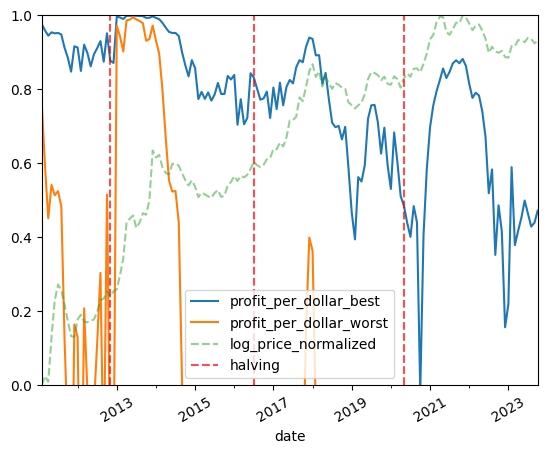

In [251]:
fig, ax = plt.subplots()
profit_per_dollar.plot(ax=ax)
log_price_normalized.plot(ax=ax, linestyle='--', alpha=0.5, label='log_price_normalized')

# Add vertical lines for halving events
for (i,date) in enumerate(halving_dates['date']):
    if i == 0:
        ax.axvline(x=date, color='red', linestyle='--', alpha=0.7, label='halving')
    else:
        ax.axvline(x=date, color='red', linestyle='--', alpha=0.7)

ax.set_ylim(0,1)
# plt.xticks(np.arange(0, len(profit_per_dollar), 12), [str(x)[:4] for x in profit_per_dollar.index[::12]])
plt.xticks(rotation=30)
plt.legend()
plt.show()

In [252]:
joules_per_coin.index = joules_per_coin['date']
joules_per_coin = joules_per_coin.drop(columns=['date'])

In [253]:
joules_per_coin

,joules_per_coin
date,
2023-10-31,1.773134e+12
2023-09-30,1.738278e+12
2023-08-31,2.031564e+12
2023-07-31,1.967182e+12
2023-06-30,1.611402e+12
...,...
2011-06-30,5.589294e+07
2011-05-31,1.667712e+07
2011-04-30,5.099443e+06


In [254]:
# Define new combinations of electricity and auxiliary costs
# electricity_costs = np.array([0.03, 0.06, 0.09, 0.12, 0.15]) / (1000*3600)
# aux_costs = np.array([1, 1.25, 1.5, 1.75, 2.0])
# colors = ['purple', 'red', 'orange', 'green', 'blue']

electricity_costs = np.array([0.03, 0.15]) / (1000*3600)
aux_costs = np.array([1, 2.0])
colors = ['green', 'red']
names = ['m_min(t)', 'm_max(t)']

# func = np.log10
func = lambda x: x

# Calculate cost per coin for each combination
cost_per_coin = [func(joules_per_coin * e * a) for (e, a) in zip(electricity_costs, aux_costs)]
cost_per_coin = [x.rename(columns={'joules_per_coin': names[i]}) for i, x in enumerate(cost_per_coin)]
cost_per_coin = pd.concat(cost_per_coin, axis=1)
cost_per_coin = cost_per_coin.iloc[::-1]

In [255]:
cost_per_coin

,m_min(t),m_max(t)
date,,
2011-02-28,0.016507,0.165068
2011-03-31,0.037427,0.374269
2011-04-30,0.042495,0.424954
2011-05-31,0.138976,1.389760
2011-06-30,0.465775,4.657745
...,...,...
2023-06-30,13428.347251,134283.472505
2023-07-31,16393.181084,163931.810837
2023-08-31,16929.701012,169297.010125


In [256]:
log_price

date
2011-02-28   -0.154902
2011-03-31   -0.036118
2011-04-30   -0.111203
2011-05-31    0.481887
2011-06-30    0.980912
                ...   
2023-06-30    4.428248
2023-07-31    4.485566
2023-08-31    4.471721
2023-09-30    4.411899
2023-10-31    4.446818
Name: price, Length: 153, dtype: float64

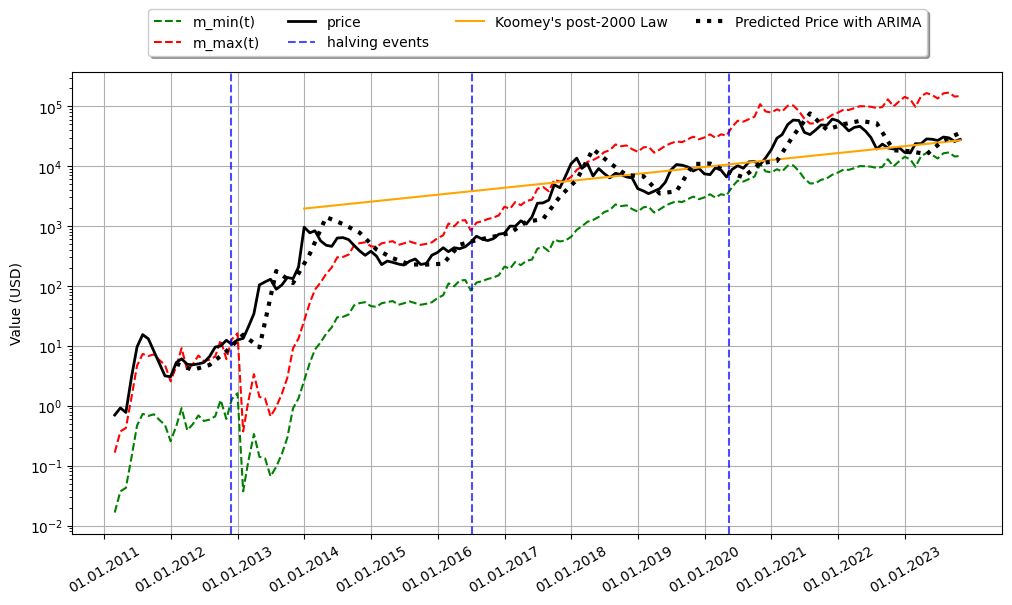

In [257]:
fig, ax = plt.subplots(figsize=(12, 6))  # Increase the width of the plot

# Plot each cost per coin with the specified colors and labels using LaTeX for subscript
for i, color in enumerate(colors):
    ax.plot(cost_per_coin.index, cost_per_coin[names[i]], linestyle='--', color=color, label=f'{names[i]}')
# ax.plot(cost_per_coin.index, cost_per_coin[f'm_{2}(t)'], linestyle='--', color="orange", label=f'Modelled mining costs')

# Plot log_price with a thick black line
ax.plot(log_price.index, 10**log_price, alpha=1, color='black', linewidth=2, label='price')

# Add vertical lines for halving events
halving_dates = pd.to_datetime(['2012-11-28', '2016-07-09', '2020-05-11', '2024-04-01'])
for date in halving_dates[:-1]:
    ax.axvline(x=date, color='blue', linestyle='--', alpha=0.7, label='halving events' if date == halving_dates[0] else "")

# Set x-ticks to every year and format them to include "01.01."
years = pd.date_range(start=Timestamp('2010-12-31 00:00:00'), end=cost_per_coin.index.max(), freq='YS')
ax.set_xticks(years)
ax.set_xticklabels([f"01.01.{year.year}" for year in years], rotation=30)

# Set y-axis label and format y-ticks to display as 10^x
ax.set_ylabel('Value (USD)', rotation='vertical')
# ax.set_yscale('log')
# ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'$10^{{{int(x)}}}$'))
ax.set_yscale('log')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'$10^{{{int(np.log10(x))}}}$'))


# Interpolate the initial price for the start_date
start_date = pd.Timestamp('2013-12-31')
if start_date not in price.index:
    initial_price = price.reindex(price.index.union([start_date])).interpolate(method='time').loc[start_date]
else:
    initial_price = price.loc[start_date]

# Add Koomey's post-2000 law
# end_date = pd.Timestamp('2030-12-31')
end_date = pd.Timestamp('2023-10-31')
koomey_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Koomey's law: Doubling efficiency every 2.6 years
koomey_values = (initial_price + 1000) * (2 ** ((koomey_dates - start_date) / pd.Timedelta(days=2.6 * 365.25)))

# Plot Koomey's law
plt.plot(koomey_dates, koomey_values, label="Koomey's post-2000 Law", color='orange')

# # Plot the predicted price
plt.plot(predicted_price['date'], predicted_price['predicted_price'], label='Predicted Price with ARIMA', linestyle=':', color='black', linewidth=3)

# add a grid
ax.grid(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(colors) + 2, fancybox=True, shadow=True)
plt.show()

In [258]:
# Calculate daily gains for each mining cost
daily_gains = pd.DataFrame(index=cost_per_coin.index)
# for i in range(5):
#     daily_gains[f'm_{i}(t)'] = (10**log_price - cost_per_coin[f'm_{i}(t)']) / cost_per_coin[f'm_{i}(t)']
for name in names[::-1]:
    daily_gains[f"{name}'s profits"] = (10**log_price - cost_per_coin[name]) / cost_per_coin[name]
# daily_gains["Profit"] = (10**log_price - cost_per_coin[f'm_min(t)']) / cost_per_coin[f'm_min(t)']

# Resample to yearly and calculate the average daily gains
yearly_gains = daily_gains.resample('Y').mean()

# Convert the gains to percentage increase
yearly_gains_percentage = yearly_gains * 100

# Format the gains as strings with percentage increase
yearly_gains_str = yearly_gains_percentage.applymap(lambda x: f'{x:+.0f}%')

# Transpose the DataFrame to have years as columns and mining costs as rows
profits_df = yearly_gains_str.T

# Display the DataFrame
profits_df

C:\Users\Timothe\AppData\Local\Temp\ipykernel_27432\3936055862.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  yearly_gains_str = yearly_gains_percentage.applymap(lambda x: f'{x:+.0f}%')


date,2011-12-31,2012-12-31,2013-12-31,2014-12-31,2015-12-31,2016-12-31,2017-12-31,2018-12-31,2019-12-31,2020-12-31,2021-12-31,2022-12-31,2023-12-31
m_max(t)'s profits,+88%,+6%,+5667%,+264%,-49%,-54%,-28%,-42%,-71%,-80%,-36%,-69%,-82%
m_min(t)'s profits,+1778%,+963%,+57572%,+3545%,+410%,+364%,+622%,+477%,+185%,+100%,+540%,+209%,+82%


In [259]:
# Calculate the log10 of the absolute values of the profits
log_abs_profits = profits_df.applymap(lambda x: np.log10(abs(float(x.strip('%').strip('+').strip('\\')) / 100)))
sign_profits = profits_df.applymap(lambda x: 1 if '+' in x else -1)

# Normalize the log profits for positive and negative values separately
max_positive = log_abs_profits[sign_profits > 0].max().max()
min_positive = log_abs_profits[sign_profits > 0].min().min()
max_negative = log_abs_profits[sign_profits < 0].max().max()
min_negative = log_abs_profits[sign_profits < 0].min().min()

def get_color(value, sign):
    if sign > 0:
        normalized_value = (value - min_positive) / (max_positive - min_positive)
        red = int((1 - normalized_value) * 255)
        green = 255
    else:
        normalized_value = (value - min_negative) / (max_negative - min_negative)
        red = 255
        green = int((1 - normalized_value) * 255)
    return f'\\cellcolor[RGB]{{{red},{green},0}}'

# Start the LaTeX table
latex_code = "\\documentclass{article}\n\\usepackage{colortbl}\n\\usepackage{booktabs}\n\\usepackage{graphicx}\n\\usepackage{array}\n\\begin{document}\n"
latex_code += "\\newcolumntype{C}[1]{>{\\centering\\arraybackslash}p{#1}}\n"
latex_code += "\\begin{table}[ht]\n\\centering\n\\resizebox{\\textwidth}{!}{%\n\\begin{tabular}{l" + "C{1.5cm}" * len(profits_df.columns) + "}\n"
latex_code += "\\toprule\n"

# Add the header row
header_row = " & " + " & ".join(profits_df.columns.strftime('%Y')) + " \\\\\n"
latex_code += header_row
latex_code += "\\midrule\n"

# Add the data rows with background colors
for index, row in profits_df.iterrows():
    row_data = " & ".join([f"{get_color(log_abs_profits.at[index, col], sign_profits.at[index, col])}" + val.replace('%', '\\%') for col, val in row.items()])
    latex_code += f"{index} & {row_data} \\\\\n"

# End the LaTeX table
latex_code += "\\bottomrule\n"
latex_code += "\\end{tabular}}\n\\caption{Yearly Profits as Percentage Increase}\n\\label{tab:profits}\n\\end{table}\n"
latex_code += "\\end{document}"

# Print the LaTeX code
print(latex_code)

\documentclass{article}
\usepackage{colortbl}
\usepackage{booktabs}
\usepackage{graphicx}
\usepackage{array}
\begin{document}
\newcolumntype{C}[1]{>{\centering\arraybackslash}p{#1}}
\begin{table}[ht]
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{lC{1.5cm}C{1.5cm}C{1.5cm}C{1.5cm}C{1.5cm}C{1.5cm}C{1.5cm}C{1.5cm}C{1.5cm}C{1.5cm}C{1.5cm}C{1.5cm}C{1.5cm}}
\toprule
 & 2011 & 2012 & 2013 & 2014 & 2015 & 2016 & 2017 & 2018 & 2019 & 2020 & 2021 & 2022 & 2023 \\
\midrule
m_max(t)'s profits & \cellcolor[RGB]{180,255,0}+88\% & \cellcolor[RGB]{255,255,0}+6\% & \cellcolor[RGB]{64,255,0}+5667\% & \cellcolor[RGB]{149,255,0}+264\% & \cellcolor[RGB]{255,122,0}-49\% & \cellcolor[RGB]{255,99,0}-54\% & \cellcolor[RGB]{255,255,0}-28\% & \cellcolor[RGB]{255,158,0}-42\% & \cellcolor[RGB]{255,34,0}-71\% & \cellcolor[RGB]{255,5,0}-80\% & \cellcolor[RGB]{255,195,0}-36\% & \cellcolor[RGB]{255,40,0}-69\% & \cellcolor[RGB]{255,0,0}-82\% \\
m_min(t)'s profits & \cellcolor[RGB]{96,255,0}+1778\% & \cellcolor[

C:\Users\Timothe\AppData\Local\Temp\ipykernel_27432\730861610.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_abs_profits = profits_df.applymap(lambda x: np.log10(abs(float(x.strip('%').strip('+').strip('\\')) / 100)))
C:\Users\Timothe\AppData\Local\Temp\ipykernel_27432\730861610.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sign_profits = profits_df.applymap(lambda x: 1 if '+' in x else -1)


In [260]:

cost_per_coin.index.min()-Timestamp('2010-01-01 00:00:00')

Timedelta('423 days 00:00:00')

In [261]:
price = 10**log_price

price = pd.DataFrame(price)
price = price.rename(columns={0: 'price'})
# price["c_mining"] = cost_per_coin["m_2(t)"]
price

,price
date,
2011-02-28,0.7000
2011-03-31,0.9202
2011-04-30,0.7741
2011-05-31,3.0331
2011-06-30,9.5700
...,...
2023-06-30,26806.9800
2023-07-31,30589.0500
2023-08-31,29629.2400


In [262]:
cost_per_coin # date m_min(t)	m_max(t)

,m_min(t),m_max(t)
date,,
2011-02-28,0.016507,0.165068
2011-03-31,0.037427,0.374269
2011-04-30,0.042495,0.424954
2011-05-31,0.138976,1.389760
2011-06-30,0.465775,4.657745
...,...,...
2023-06-30,13428.347251,134283.472505
2023-07-31,16393.181084,163931.810837
2023-08-31,16929.701012,169297.010125


Alpha: 1.4845998481021498
Beta: 0.7204375433821413
Alpha: 0.7641623047200073
Beta: 0.7204375433821414


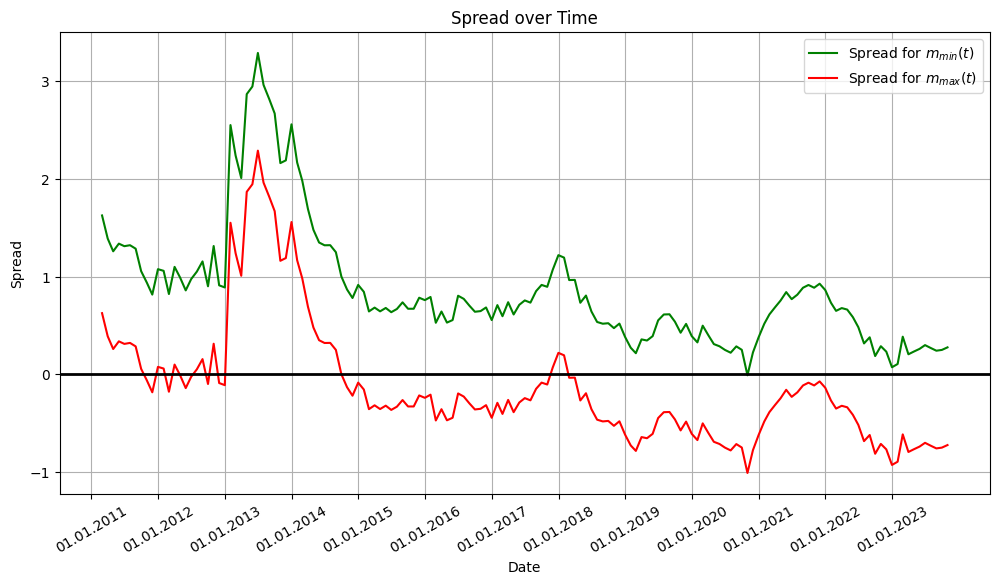

In [263]:
# Calculate log10 of price and c_mining
price['log_price'] = np.log10(price['price'])
price['log_m_min'] = np.log10(cost_per_coin['m_min(t)'])
price['log_m_max'] = np.log10(cost_per_coin['m_max(t)'])

# Plot the spread over time
plt.figure(figsize=(12, 6))

i = 0
for thing in [price['log_m_min'], price['log_m_max']]:
    # Perform linear regression to find alpha and beta
    X = thing
    y = price['log_price']
    X = sm.add_constant(X)  # Adds a constant term to the predictor

    model = sm.OLS(y, X).fit()
    alpha = model.params['const']
    beta = model.params[thing.name]

    print(f"Alpha: {alpha}")
    print(f"Beta: {beta}")

    # Calculate the spread
    # spread = price['log_price'] - beta * thing - alpha
    spread = price['log_price'] - thing
    plt.plot(price.index, spread, label='Spread' + " for $" + names[i].replace("m_","m_{").replace("(","}(") + "$", color=colors[i])
    i += 1

spread = price['log_price'] - beta * thing - alpha
plt.xlabel('Date')
plt.ylabel('Spread')
plt.title('Spread over Time')
plt.legend()


# set_xticklabels
years = pd.date_range(start=Timestamp('2010-12-31 00:00:00'), end=price.index.max(), freq='YS')
plt.xticks(years, [f"01.01.{year.year}" for year in years], rotation=30)
plt.xticks(rotation=30)
plt.grid(True)

# Add a thick line at y=0
plt.axhline(y=0, color='black', linewidth=2)

plt.show()

In [265]:
spread

date
2011-02-28   -0.355439
2011-03-31   -0.492786
2011-04-30   -0.607608
2011-05-31   -0.385255
2011-06-30   -0.264629
                ...   
2023-06-30   -0.030334
2023-07-31   -0.035435
2023-08-31   -0.059357
2023-09-30   -0.070397
2023-10-31   -0.041689
Length: 153, dtype: float64

In [266]:
spread_full = spread
spread_before_turning_point = spread.loc[:'2013-07-01']
spread_after_turning_point = spread.loc['2013-07-01':]

In [268]:
# # Perform Augmented Dickey-Fuller test
# adf_result = adfuller(price['spread'])
# print('ADF Statistic:', adf_result[0])
# print('p-value:', adf_result[1])
# for key, value in adf_result[4].items():
#     print('Critical Values:')
#     print(f'   {key}, {value}')

# # Interpretation of the ADF test
# if adf_result[1] < 0.05:
#     print("The spread is stationary (reject the null hypothesis of a unit root).")
# else:
#     print("The spread is not stationary (fail to reject the null hypothesis of a unit root).")


from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform Ljung-Box test
ljung_box_result = acorr_ljungbox(spread_full, lags=[10], return_df=True)
print(ljung_box_result)

# Interpretation of the Ljung-Box test
if ljung_box_result['lb_pvalue'].values[0] < 0.05:
    print("The spread is not white noise (reject the null hypothesis of no autocorrelation).")
else:
    print("The spread is white noise (fail to reject the null hypothesis of no autocorrelation).")


# from statsmodels.tsa.stattools import variance_ratio

# # Perform Variance Ratio test
# vr_result = variance_ratio(price['spread'])
# print('Variance Ratio:', vr_result)

# # Interpretation of the Variance Ratio test
# if vr_result < 1:
#     print("The spread is likely to be mean-reverting (not a random walk).")
# else:
#     print("The spread is likely to be a random walk (noise).")


# from scipy.signal import periodogram

# # Perform Spectral Analysis
# frequencies, spectrum = periodogram(price['spread'])

# plt.figure(figsize=(12, 6))
# plt.plot(frequencies, spectrum)
# plt.xlabel('Frequency')
# plt.ylabel('Spectral Density')
# plt.title('Spectral Density of the Spread')
# plt.show()

# Interpretation: A flat spectral density indicates white noise.

       lb_stat      lb_pvalue
10  561.552719  3.018675e-114
The spread is not white noise (reject the null hypothesis of no autocorrelation).


In [ ]:
predicted_d_ln_price_df = pd.read_csv('predictions_Quarterly Data_1_1.csv') # date	predicted_d_ln_price
predicted_d_ln_price_df['date'] = pd.to_datetime(predicted_d_ln_price_df['date'])
ln_price = np.log(price['price'])
predicted_price = predicted_d_ln_price_df.copy()

In [ ]:
# ln_price.loc["2023-06-30"]

In [ ]:
predicted_price

,date,predicted_d_ln_price
0,2020-10-31,0.137904
1,2021-01-31,0.087864
2,2021-04-30,0.257581
3,2021-07-31,0.234906
4,2021-10-31,0.068401
5,2022-01-31,0.201714
6,2022-04-30,0.139961
7,2022-07-31,-0.029190
8,2022-10-31,-0.081949
9,2023-01-31,-0.061788


In [ ]:


# go through each (date, predicted_d_ln_price) pair and obtain the predicted price of the next quarter
for i, row in predicted_price.iterrows():
    date = row['date']
    predicted_d_ln_price = row['predicted_d_ln_price']
    # calculate the predicted price of the next quarter
    predicted_price.at[i, 'predicted_ln_price'] = ln_price.loc[date] + predicted_d_ln_price
    predicted_price.at[i, 'ln_price'] = ln_price.loc[date]

# shift the predicted price by one index
predicted_price['predicted_ln_price'] = predicted_price['predicted_ln_price'].shift(1)
predicted_price = predicted_price.dropna()
predicted_price['predicted_price'] = np.exp(predicted_price['predicted_ln_price'])
predicted_price['price'] = np.exp(predicted_price['ln_price'])
predicted_price

C:\Users\Timothe\AppData\Local\Temp\ipykernel_38072\3330187954.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_price['predicted_price'] = np.exp(predicted_price['predicted_ln_price'])
C:\Users\Timothe\AppData\Local\Temp\ipykernel_38072\3330187954.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_price['price'] = np.exp(predicted_price['ln_price'])


,date,predicted_d_ln_price,predicted_ln_price,ln_price,predicted_price,price
1,2021-01-31,0.087864,9.407861,10.285349,12183.784977,29300.190936
2,2021-04-30,0.257581,10.373213,10.981142,31991.103654,58755.615178
3,2021-07-31,0.234906,11.238723,10.423134,76017.786465,33628.670000
4,2021-10-31,0.068401,10.658040,10.780629,42533.204856,48080.372838
5,2022-01-31,0.201714,10.849030,10.769421,51484.199852,47544.499400
6,2022-04-30,0.139961,10.971135,10.741406,58170.593391,46231.004759
7,2022-07-31,-0.029190,10.881367,9.869729,53176.261690,19336.104441
8,2022-10-31,-0.081949,9.840539,9.868128,18779.832376,19305.171900
9,2023-01-31,-0.061788,9.786179,9.717584,17786.214948,16607.069459
10,2023-04-30,-0.078342,9.655796,10.256424,15612.005938,28464.814018


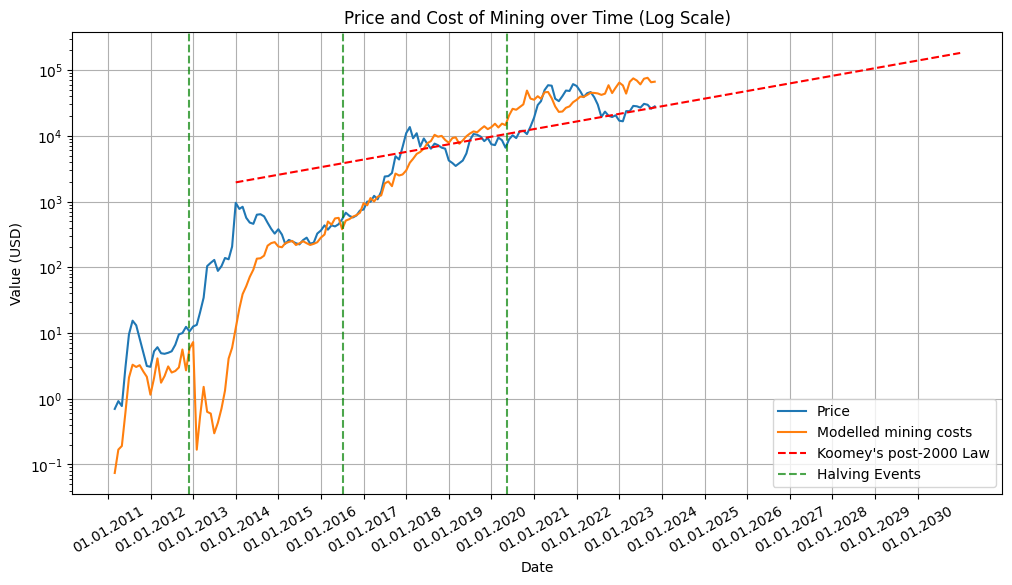

In [ ]:
# Interpolate the initial price for the start_date
start_date = pd.Timestamp('2013-12-31')
if start_date not in price.index:
    initial_price = price['price'].reindex(price.index.union([start_date])).interpolate(method='time').loc[start_date]
else:
    initial_price = price.loc[start_date, 'price']

# Plot the original price and c_mining on a log scale
plt.figure(figsize=(12, 6))
plt.plot(price.index, price['price'], label='Price')
plt.plot(price.index, price['c_mining'], label='Modelled mining costs')
plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Value (USD)')
plt.title('Price and Cost of Mining over Time (Log Scale)')


# Add Koomey's post-2000 law
end_date = pd.Timestamp('2030-12-31')
koomey_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Koomey's law: Doubling efficiency every 2.6 years
koomey_values = (initial_price + 1000) * (2 ** ((koomey_dates - start_date) / pd.Timedelta(days=2.6 * 365.25)))

# Plot Koomey's law
plt.plot(koomey_dates, koomey_values, label="Koomey's post-2000 Law", linestyle='--', color='red')

# # Plot the predicted price
# plt.plot(predicted_price['date'], predicted_price['predicted_price'], label='Predicted Price', linestyle='--', color='green')

# Plot the halvings
halving_dates = pd.to_datetime(['2012-11-28', '2016-07-09', '2020-05-11', '2024-04-01'])
for date in halving_dates[:-1]:
    plt.axvline(x=date, color='green', linestyle='--', alpha=0.7, label='Halving Events' if date == halving_dates[0] else "")


# Set x-ticks to show years
years = pd.date_range(start=Timestamp('2010-12-31 00:00:00'), end=end_date, freq='YS')
plt.xticks(years, [f"01.01.{year.year}" for year in years], rotation=30)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
c_mining = pd.DataFrame(price['c_mining'])
c_mining = c_mining.rename(columns={'c_mining': 'cost_per_coin'})
c_mining

,cost_per_coin
date,
2011-02-28,0.074281
2011-03-31,0.168421
2011-04-30,0.191229
2011-05-31,0.625392
2011-06-30,2.095985
...,...
2023-06-30,60427.562627
2023-07-31,73769.314877
2023-08-31,76183.654556


In [ ]:
c_mining.to_csv('cost_per_coin.csv', index=True)

In [ ]:
from sklearn.metrics import r2_score
# Interpolate the costs and price to match the dates of Koomey's law
price_interpolated = price['price'].reindex(koomey_dates).interpolate(method='time')
c_mining_interpolated = price['c_mining'].reindex(koomey_dates).interpolate(method='time')

# Transform to log10 scale
log_koomey_values = np.log10(koomey_values)
log_price_interpolated = np.log10(price_interpolated)
log_c_mining_interpolated = np.log10(c_mining_interpolated)

# Calculate R^2 between Koomey's law and costs in log10 scale
r2_costs_log = r2_score(log_c_mining_interpolated, log_koomey_values)
print(f"R^2 between Koomey's law and costs (log10 scale): {r2_costs_log}")

# Calculate R^2 between Koomey's law and price in log10 scale
r2_price_log = r2_score(log_price_interpolated, log_koomey_values)
print(f"R^2 between Koomey's law and price (log10 scale): {r2_price_log}")



R^2 between Koomey's law and costs (log10 scale): 0.6578598717722545
R^2 between Koomey's law and price (log10 scale): 0.49164816423599866


In [ ]:
# Calculate archaicity profits
df = pd.read_csv('../bitcoinforum/6_calculating_costs/monthly_stuff.csv')
df['date'] = pd.to_datetime(df['date'])
seconds_in_block = 600
df = df[['date', 'hashrate', 'price', 'max_efficiency', 'coins_per_block']]
df = df.iloc[::-1]
df['max_efficiency'] = df['max_efficiency'].ffill()
df['max_efficiency'] = df['max_efficiency'] * 1e12
df.index = df['date']
df = df.drop(columns=['date'])

In [ ]:
df

,hashrate,price,max_efficiency,coins_per_block
date,,,,
2011-02-28,3.117778e+11,0.7000,3.780000e+06,50.00
2011-03-31,5.482000e+11,0.9202,3.780000e+06,50.00
2011-04-30,7.260000e+11,0.7741,3.780000e+06,50.00
2011-05-31,2.244000e+12,3.0331,3.780000e+06,50.00
2011-06-30,7.758000e+12,9.5700,3.780000e+06,50.00
...,...,...,...,...
2023-06-30,3.699255e+20,26806.9800,4.650000e+10,6.25
2023-07-31,3.750404e+20,30589.0500,4.650000e+10,6.25
2023-08-31,3.853479e+20,29629.2400,4.650000e+10,6.25


In [ ]:
# Constants
electricity_cost_per_joule = 0.10 / (1000 * 3600)  # USD per joule
seconds_in_block = 600

# Function to calculate mining cost
def calculate_mining_cost(hashrate, max_efficiency, coins_per_block):
    joules_per_hash = 1 / max_efficiency
    joules_per_block = hashrate * seconds_in_block * joules_per_hash
    cost_per_block = joules_per_block * electricity_cost_per_joule
    return cost_per_block / coins_per_block

# Initialize a DataFrame to store the results
archaicity_df = pd.DataFrame(index=df.index, columns=['archaicity_months'])

# Iterate through each month
for current_month in df.index:
    max_efficiency = df.loc[current_month, 'max_efficiency']
    archaicity_months = 0
    
    # Iterate through the next months
    for future_month in df.loc[current_month:].index:
        future_hashrate = df.loc[future_month, 'hashrate']
        future_price = df.loc[future_month, 'price']
        future_coins_per_block = df.loc[future_month, 'coins_per_block']
        
        # Calculate mining cost
        mining_cost = calculate_mining_cost(future_hashrate, max_efficiency, future_coins_per_block)
        
        # Check if mining is still profitable
        if mining_cost < future_price:
            archaicity_months += 1
        else:
            break
    
    # Store the result
    archaicity_df.loc[current_month, 'archaicity_months'] = archaicity_months

# Resample to yearly and take the mean
yearly_archaicity = archaicity_df.resample('Y').mean()

print(yearly_archaicity)

           archaicity_months
date                        
2011-12-31         28.272727
2012-12-31         21.166667
2013-12-31         26.666667
2014-12-31              28.0
2015-12-31         34.416667
2016-12-31             26.25
2017-12-31              15.5
2018-12-31          6.083333
2019-12-31              11.0
2020-12-31              11.5
2021-12-31              15.5
2022-12-31              10.0
2023-12-31               5.5


In [ ]:
latex_table = yearly_archaicity.to_latex(index=True, header=True, caption="Yearly Archaicity of Bitcoin Mining Hardware", label="tab:yearly_archaicity", float_format="%.2f")
print(latex_table)

\begin{table}
\caption{Yearly Archaicity of Bitcoin Mining Hardware}
\label{tab:yearly_archaicity}
\begin{tabular}{ll}
\toprule
 & archaicity_months \\
date &  \\
\midrule
2011-12-31 00:00:00 & 28.27 \\
2012-12-31 00:00:00 & 21.17 \\
2013-12-31 00:00:00 & 26.67 \\
2014-12-31 00:00:00 & 28.00 \\
2015-12-31 00:00:00 & 34.42 \\
2016-12-31 00:00:00 & 26.25 \\
2017-12-31 00:00:00 & 15.50 \\
2018-12-31 00:00:00 & 6.08 \\
2019-12-31 00:00:00 & 11.00 \\
2020-12-31 00:00:00 & 11.50 \\
2021-12-31 00:00:00 & 15.50 \\
2022-12-31 00:00:00 & 10.00 \\
2023-12-31 00:00:00 & 5.50 \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
transposed_yearly_archaicity = yearly_archaicity.T
transposed_yearly_archaicity = transposed_yearly_archaicity*30.44
# Export to LaTeX
latex_table = transposed_yearly_archaicity.to_latex(index=False,float_format="%.2f")
print(latex_table)

\begin{tabular}{lllllllllllll}
\toprule
2011-12-31 00:00:00 & 2012-12-31 00:00:00 & 2013-12-31 00:00:00 & 2014-12-31 00:00:00 & 2015-12-31 00:00:00 & 2016-12-31 00:00:00 & 2017-12-31 00:00:00 & 2018-12-31 00:00:00 & 2019-12-31 00:00:00 & 2020-12-31 00:00:00 & 2021-12-31 00:00:00 & 2022-12-31 00:00:00 & 2023-12-31 00:00:00 \\
\midrule
860.62 & 644.31 & 811.73 & 852.32 & 1047.64 & 799.05 & 471.82 & 185.18 & 334.84 & 350.06 & 471.82 & 304.40 & 167.42 \\
\bottomrule
\end{tabular}



In [ ]:
# Calculate archaicity
df = pd.read_csv('../bitcoinforum/6_calculating_costs/monthly_stuff.csv')
df['date'] = pd.to_datetime(df['date'])
df = df[['date', 'efficiency', 'max_efficiency']]
df = df.iloc[::-1]
df['max_efficiency'] = df['max_efficiency'].ffill()
df['max_efficiency'] = df['max_efficiency'] * 1e12
df.index = df['date']
df = df.drop(columns=['date'])
df

,efficiency,max_efficiency
date,,
2011-02-28,1.888783e+06,3.780000e+06
2011-03-31,1.464722e+06,3.780000e+06
2011-04-30,1.708422e+06,3.780000e+06
2011-05-31,1.614668e+06,3.780000e+06
2011-06-30,1.665613e+06,3.780000e+06
...,...,...
2023-06-30,2.203848e+10,4.650000e+10
2023-07-31,1.830227e+10,4.650000e+10
2023-08-31,1.820932e+10,4.650000e+10


In [ ]:
# Initialize a DataFrame to store the results
efficiency_df = pd.DataFrame(index=df.index, columns=['months_until_surpassed'])

# Iterate through each month
for current_month in df.index:
    max_efficiency = df.loc[current_month, 'max_efficiency']
    months_until_surpassed = 0
    
    # Iterate through the next months
    for future_month in df.loc[current_month:].index:
        future_efficiency = df.loc[future_month, 'efficiency']
        
        # Check if future efficiency surpasses current month's max efficiency
        if future_efficiency > max_efficiency:
            break
        else:
            months_until_surpassed += 1
    
    # Store the result
    efficiency_df.loc[current_month, 'months_until_surpassed'] = months_until_surpassed

# Resample to yearly and take the mean
yearly_efficiency = efficiency_df.resample('Y').mean()

print(yearly_efficiency)

           months_until_surpassed
date                             
2011-12-31              12.272727
2012-12-31               6.916667
2013-12-31              18.333333
2014-12-31                  19.25
2015-12-31              18.083333
2016-12-31                  26.25
2017-12-31                   20.5
2018-12-31              16.083333
2019-12-31                   48.5
2020-12-31                   40.5
2021-12-31                   28.5
2022-12-31                   16.5
2023-12-31                    5.5


In [ ]:
transposed_yearly_archaicity = yearly_archaicity.T
transposed_yearly_archaicity = transposed_yearly_archaicity*30.44
# Export to LaTeX
latex_table = transposed_yearly_archaicity.to_latex(index=False,float_format="%.2f")
print(latex_table)

\begin{tabular}{lllllllllllll}
\toprule
2011-12-31 00:00:00 & 2012-12-31 00:00:00 & 2013-12-31 00:00:00 & 2014-12-31 00:00:00 & 2015-12-31 00:00:00 & 2016-12-31 00:00:00 & 2017-12-31 00:00:00 & 2018-12-31 00:00:00 & 2019-12-31 00:00:00 & 2020-12-31 00:00:00 & 2021-12-31 00:00:00 & 2022-12-31 00:00:00 & 2023-12-31 00:00:00 \\
\midrule
860.62 & 644.31 & 811.73 & 852.32 & 1047.64 & 799.05 & 471.82 & 185.18 & 334.84 & 350.06 & 471.82 & 304.40 & 167.42 \\
\bottomrule
\end{tabular}



# part 2

In [ ]:
# PART 2
# Plotting the market cap


# this csv only goes back to 2014
# df = pd.read_csv('../pricehistory/price_full.csv')
# btcmarketcap = df[['Start','Market Cap']]
# btcmarketcap.set_index('Start', inplace=True)
# btcmarketcap = btcmarketcap.iloc[::-1]
# btcmarketcap = btcmarketcap[btcmarketcap['Market Cap'] != 0]
# btcmarketcap["day"] = btcmarketcap.index
# btcmarketcap.reset_index(drop=True, inplace=True)
# btcmarketcap

In [ ]:
df = pd.read_csv('bitcoin@public.csv',delimiter=';')
btcmarketcap = df[["CapMrktCurUSD","Date"]].dropna()
btcmarketcap.rename(columns={"CapMrktCurUSD":"Market Cap","Date":"day"},inplace=True)
btcmarketcap["day"] = pd.to_datetime(btcmarketcap["day"])
btcmarketcap.index = btcmarketcap["day"]
btcmarketcap = btcmarketcap[["Market Cap"]]

# create a january first for each year and interpolate the market cap
for year in range(2014,2022):
    btcmarketcap.loc[pd.to_datetime(f"{year}-01-01")] = np.nan
btcmarketcap.sort_index(inplace=True)
btcmarketcap.interpolate(inplace=True)

btcmarketcap["day"] = btcmarketcap.index
# looks like
# 4730	6.864460e+11	2021-06-01
# 4731	5.947511e+11	2021-07-15
btcmarketcap

In [ ]:
# plot btcmarketcap with log10 y axis, x axis is year and at a 30 degree angle
fig, ax = plt.subplots()
btcmarketcap.plot(ax=ax)
ax.set_yscale('log')
# since the days are not evenly spaced, we can't use np.arange
# plt.xticks([btcmarketcap.index[0],btcmarketcap.index[-1]], [str(btcmarketcap["day"].iloc[0])[:4],str(btcmarketcap["day"].iloc[-1])[:4]])
plt.xticks(rotation=30)
plt.show()

In [ ]:
# from https://data.un.org/
gdp = pd.read_csv('gdp.csv', encoding='ISO-8859-1') # Country,Year,TypeOfValue,Value
gdp = gdp[gdp['TypeOfValue'] == 'GDP in current prices (millions of US dollars)']
gdp = gdp[["Country","Year","Value"]]
gdp = gdp.reset_index(drop=True)
# ignore all rows that come before the first row that has "Afghanistan" in the country column
gdp = gdp.iloc[gdp[gdp['Country'] == 'Afghanistan'].index[0]:]
gdp = gdp.reset_index(drop=True)
gdp["Value"] = gdp["Value"].str.replace(",","").astype(float)*1e6
gdp # now looks like: 0	Afghanistan	1995 2.757000e+09

In [ ]:
# Step 1: Take the natural logarithm of every value in the 'Value' and 'Market Cap' columns
gdp['ln_Value'] = np.log(gdp['Value'])
btcmarketcap['ln_Market_Cap'] = np.log(btcmarketcap['Market Cap'])

first_year = 2011

# Step 2: Interpolate missing GDP values for each country from first_year to 2021
# First, pivot the gdp dataframe for easier manipulation
gdp_pivot = gdp.pivot(index='Country', columns='Year', values='ln_Value')

# Interpolate linearly across the years for each country
gdp_interpolated = gdp_pivot.reindex(columns=range(1995, 2022)).interpolate(axis=1)

# Filter out the years we are interested in (first_year-2021)
gdp_interpolated = gdp_interpolated.loc[:, first_year:2021]

# Step 3: Extract Bitcoin market cap for each January 1st from first_year to 2021
btcmarketcap['Date'] = pd.to_datetime(btcmarketcap['day'])
btc_jan_1st = btcmarketcap[btcmarketcap['Date'].dt.month == 1]
btc_jan_1st = btc_jan_1st[btc_jan_1st['Date'].dt.day == 1]
btc_jan_1st = btc_jan_1st.set_index(btc_jan_1st['Date'].dt.year)
btc_jan_1st = btc_jan_1st.loc[first_year:2021, 'ln_Market_Cap']

# Step 4: Rank Bitcoin market cap among the countries' GDPs and plot the rankings
rankings = pd.DataFrame(index=range(first_year, 2022))
for year in range(first_year, 2022):
    year_gdp = gdp_interpolated[year].dropna()
    btc_cap = btc_jan_1st.loc[year]
    rank = (year_gdp < btc_cap).sum() + 1  # Ranking position; +1 because rank starts from 1
    rankings.loc[year, 'Rank'] = rank

# Step 5, take the amount of countries and substrack the rankings
countries_count = gdp_interpolated.shape[0]
rankings['Rank'] = countries_count - rankings['Rank'] + 1

# Plotting the rankings
plt.figure(figsize=(10, 6))
plt.plot(rankings.index, rankings['Rank'], marker='o')
plt.title('Bitcoin Market Cap Ranking Among Countries by GDP')
plt.xlabel('Year')
plt.ylabel('Rank (Top x)')
plt.grid(True)
# invert y axis
plt.gca().invert_yaxis()
plt.show()

In [ ]:
countries_count

In [ ]:
np.array(gdp_interpolated.index)